In [2]:
%matplotlib inline

In [20]:
from __future__ import division , print_function

import glob
import os
import ConfigParser
import time

import numpy as np
import pylab as plt

import errno
import sys
sys.path.insert(0, '/opt/usr/python/') # path to actual astra installation
import astra

In [4]:
def mkdir_p(path):
    '''
    Create directory if absent
    '''
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def find_tomo_config(data_root):
    """
    Retrun path to logfile in directory  
    """
    log_files = glob.glob(os.path.join(data_root,'*.log'))
    if len(log_files) == 0:
        raise IOError('Config file not found')
    else:
        return log_files[0]
    
def read_config(config_path):
    """
    Parse config, return dictionary
    """
    def as_dict(config):
        d = dict(config._sections)
        for k in d:
            d[k] = dict(config._defaults, **d[k])
            d[k].pop('__name__', None)
        return d
    
    config = ConfigParser.RawConfigParser()
    config.optionxform = str
    config.read(config_path)
    res = as_dict(config)
    return res

def check_datafiles(data_files):
    '''
    Check that all file in sequence present
    '''
    for idf, df in enumerate(data_files):
        if not '{:04d}.tif'.format(idf) in df:
            raise ValueError('!!! File number {} missing. Found {}'.format(idf, df))

In [18]:
def show_cuts(data):
    """
    Show voulume cut in 2 cental slices in ortogonal directions
    """
    plt.figure(figsize=(10,10))
    plt.imshow(data[data.shape[0]//2])
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(data[:,data.shape[1]//2,:])
    plt.colorbar()
    plt.show()

In [6]:
def build_geometry(angles, slices_number, rec_size,  pixel_size, os_distance, ds_distance):
    """
    Build astra circular geometry for square detector.  See example #5 from python samples
    """
    

#     # All distances in [pixels] (MMC1 dataset configuration)
    
#     pixel_size = 2.82473e-3
#     os_distance = 56.135 / pixel_size # object-sample distance
#     ds_distance = 225.082 / pixel_size # detector-sample distance
    detector_size = rec_size
    
    # Circular

    # Parameters: width of detector column, height of detector row, #rows, #columns,
    #             angles, distance source-origin, distance origin-detector
    
    proj_geom = astra.create_proj_geom('cone', ds_distance / os_distance,ds_distance / os_distance,
                                       slices_number, detector_size, angles,
                                       os_distance, (ds_distance - os_distance))
    return proj_geom


In [7]:
def read_data(config, tmp_dir):
    '''
    Load data from images to memory maped file 'images.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    
    object_name = config['Acquisition']['Filename Prefix']

    print('Object name:\t', object_name)

    #find projections files
    data_files  = glob.glob(os.path.join(raw_dir,object_name+'[0-9]'*4+'.tif'))
    data_files = sorted(data_files)

    print('Data files found:', len(data_files))
    print('First file:', data_files[0])
    print('Last file:', data_files[-1])
    
    check_datafiles(data_files)
    images_num = len(data_files)
    data_tmp_file = os.path.join(tmp_dir,'images.tmp')
    data_tmp_size_file = os.path.join(tmp_dir,'images.size.txt')
    if os.path.exists(data_tmp_file) and os.path.exists(data_tmp_size_file):
        print('File {} found, read it. Not load original images'.format(data_tmp_file))
        data_blob = np.memmap(data_tmp_file,
                      dtype='uint16',
                      shape=tuple(np.loadtxt(data_tmp_size_file).astype('uint16')),
                      mode='r+'
                     )
    else:
        data_blob = np.memmap(data_tmp_file,
                      dtype='uint16',
                      shape=(images_num,
                             int(config['Acquisition']['Number of Rows']),
                             int(config['Acquisition']['Number of Columns'])),
                      mode='w+'
                     )
        np.savetxt(os.path.join(tmp_dir,'images.size.txt'), data_blob.shape,fmt='%5u')

        for idf, data_file in enumerate(data_files):
            data_blob[idf] = plt.imread(data_files[idf])
            
    return data_blob

def preprocess_sinogramm(data_blob, tmp_dir):
    '''
    Calculate log from sinogram and normalise each frame to maximum in this frame.
    Save result to mmaped file 'sinogram.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    
    sinogram_blob_file = os.path.join(tmp_dir,'sinogram.tmp')
    sinogram_blob_size_file = os.path.join(tmp_dir,'sinogram.size.txt')
    
    if os.path.exists(sinogram_blob_file) and os.path.exists(sinogram_blob_size_file):
        print('File {} found, read it. Not load original images'.format(sinogram_blob_file))
        sinogram_blob =  np.memmap(sinogram_blob_file,
                      dtype='float32',
                      shape= tuple(np.loadtxt(sinogram_blob_size_file).astype('uint16')),
                      mode='r+'
                     )
    else:
        sinogram_blob =  np.memmap(sinogram_blob_file,
                      dtype='float32',
                      shape= data_blob.shape,
                      mode='w+'
                     )

        np.savetxt(sinogram_blob_size_file, data_blob.shape,fmt='%5u')

        for im_numb in range(data_blob.shape[0]):
            sinogram_blob[im_numb] = -np.log(data_blob[im_numb].astype('float32')/data_blob[im_numb].max())
            
    return sinogram_blob

def find_start_stop_slices(optical_axis, sinogram_blob):
    '''
    Calculate first and last slice on image based on positin of optical axis
    '''
    if optical_axis <=sinogram_blob.shape[1]//2:
        start_line = sinogram_blob.shape[1] - (optical_axis*2+1)
        stop_line = sinogram_blob.shape[1]
    else:
        start_line = 0
        stop_line = optical_axis*2+1
    return start_line, stop_line

def crop_sinogram(sinogram_blob, start_line, stop_line):
    '''
    Crop sinogram so optical axis in the center of the image.
    Save sinogram in format that can be maped (linked) to ASTRA.
    Save result to mmaped file 'sinogram_croped.tmp' in tmp_dir
    If mmaped file exist - read it
    '''
    sinogram_croped_file = os.path.join(tmp_dir,'sinogram_croped.tmp')
    sinogram_croped_size_file = os.path.join(tmp_dir,'sinogram_croped.size.txt')
    if os.path.exists(sinogram_croped_file) and os.path.exists(sinogram_croped_size_file):
        print('File {} found, read it. Not load original images'.format(sinogram_croped_file))
        sinogram_croped_blob =  np.memmap(sinogram_croped_file,
              dtype='float32',
              shape= tuple(np.loadtxt(sinogram_croped_size_file).astype('uint16')),
              mode='r+'
             )
    else:
        sinogram_croped_blob =  np.memmap(sinogram_croped_file,
              dtype='float32',
              shape= (stop_line-start_line,sinogram_blob.shape[0],sinogram_blob.shape[-1]),
              mode='w+'
             )

        np.savetxt(sinogram_croped_size_file, sinogram_blob.shape,fmt='%5u')
        for im_numb in range(sinogram_blob.shape[0]):
            sinogram_croped_blob[:,im_numb,:] = sinogram_blob[im_numb, start_line:stop_line, :]

    return sinogram_croped_blob
    
def reconstruct(config, sinogram_croped_blob, tmp_dir):
    '''
    Reconstruct using FDK method.
    Result saved to rec.tmp in tmp_dir.
    '''
    astra.astra.set_gpu_index([0,1])
    angles_step = float(config['Acquisition']['Rotation Step (deg)'])

    angles = np.arange(sinogram_croped_blob.shape[1])*angles_step
    angles = angles.astype('float64')/180.*np.pi

    rec_size = sinogram_croped_blob.shape[-1]
    slices_number = sinogram_croped_blob.shape[0]

    pixel_size = float(config['Acquisition']['Image Pixel Size (um)']) *1e-3
    os_distance = float(config['Acquisition']['Object to Source (mm)']) / pixel_size
    ds_distance = float(config['Acquisition']['Camera to Source (mm)']) /pixel_size

    proj_geom = build_geometry(angles, slices_number, rec_size, pixel_size, os_distance, ds_distance)
    # sinogram_id = astra.data3d.create('-sino', proj_geom, np.rollaxis(sinogram_croped_blob,-1))  #fix it

    proj_id = astra.data3d.link('-sino', proj_geom, sinogram_croped_blob)  #fix it


    vol_geom = astra.create_vol_geom((rec_size, rec_size, slices_number))

    rec_volume = np.memmap(os.path.join(tmp_dir,'rec.tmp'),
                                dtype='float32', mode='w+', 
                                shape=(slices_number,rec_size, rec_size)
                           )
    np.savetxt(os.path.join(tmp_dir,'rec.size.txt'), rec_volume.shape,fmt='%5u')

    rec_id = astra.data3d.link('-vol', vol_geom, rec_volume)

     # Set up the parameters for a reconstruction algorithm using the GPU
    # Complete list of suporteed algoritms can be found http://www.astra-toolbox.com/docs/algs/index.html

    print('Start reconstruction')
    t=time.time()
    cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = proj_id
    cfg['option'] = {'ShortScan': True}

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # For FDK number of iterationa my be 1
    astra.algorithm.run(alg_id, 1)

    print('Stop reconstruction')
    print(time.time()-t)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.data3d.info()
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(proj_id)
    astra.data3d.delete(rec_id)
    astra.data3d.clear()
    return rec_volume

Object name:	 MMC1_2.82um_
Data files found: 2029
First file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_0000.tif
Last file: /diskmnt/a/makov/yaivan/MMC_1/Raw/MMC1_2.82um_2028.tif
(2029, 2096, 4000)


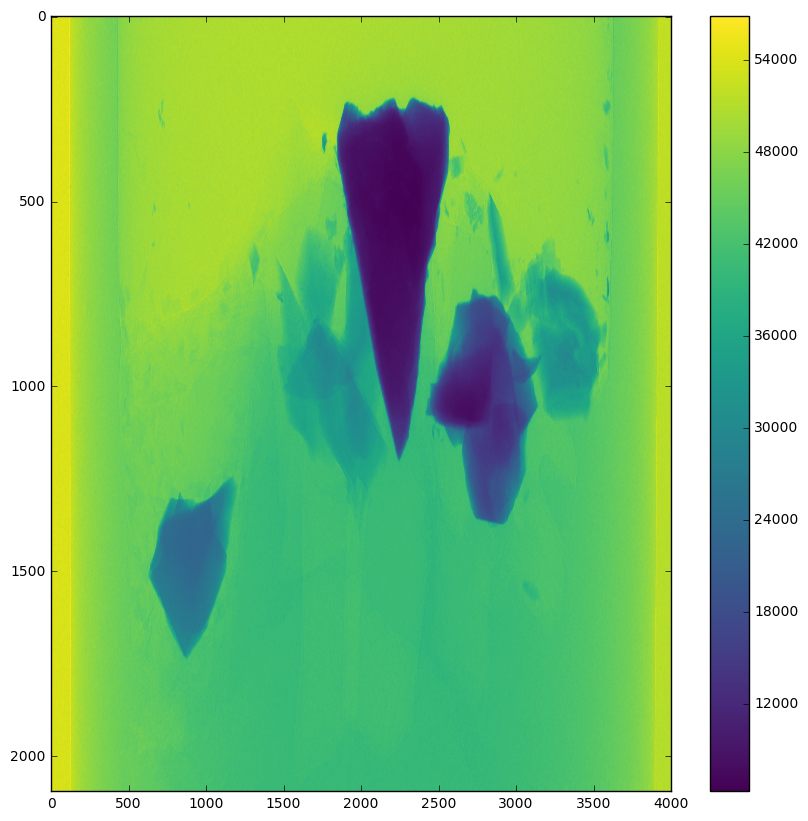

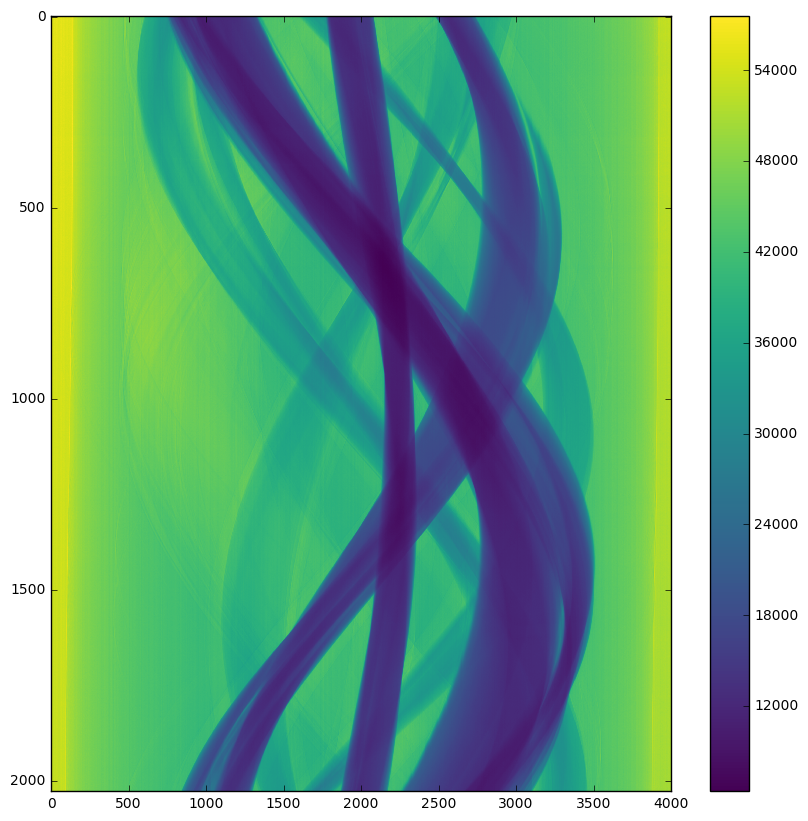

Time : 3.74015402794


In [8]:
# reading config and images from disk
t=time.time()

#set global colormap for show slices
plt.viridis()

raw_dir = '/diskmnt/a/makov/yaivan/MMC_1/Raw/'  #  Directory with raw files
tmp_dir = '/diskmnt/fast/makov/tmp/'  #  Directory for memory maped files

mkdir_p(tmp_dir)

config_file = find_tomo_config(raw_dir)
config = read_config(config_file)

data_blob = read_data(config, tmp_dir)

print(data_blob.shape)
show_cuts(data_blob)
    
print('Time : {}'.format(time.time()-t))

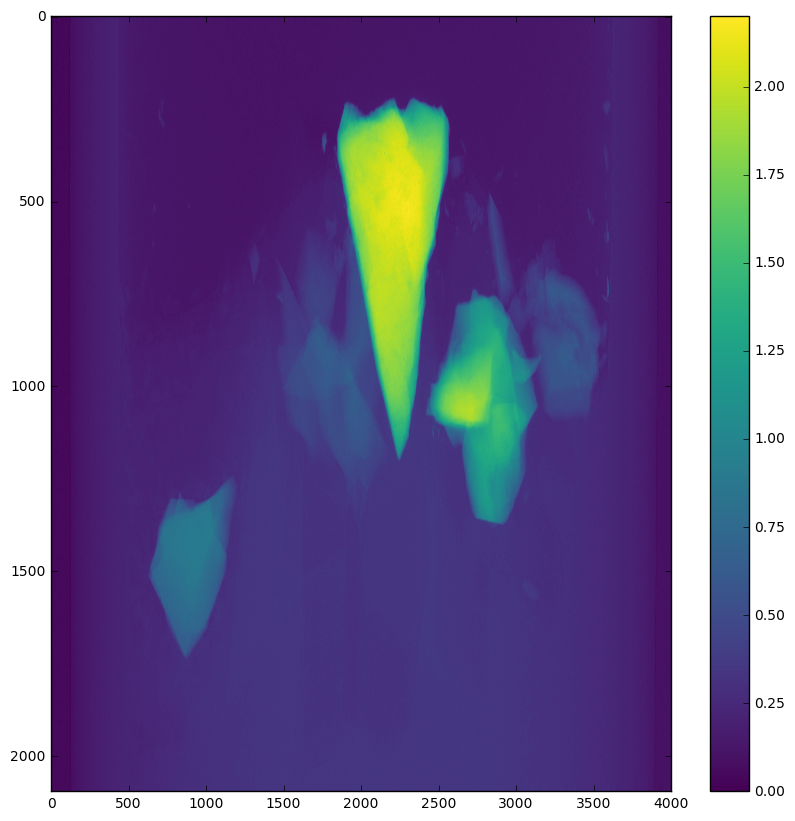

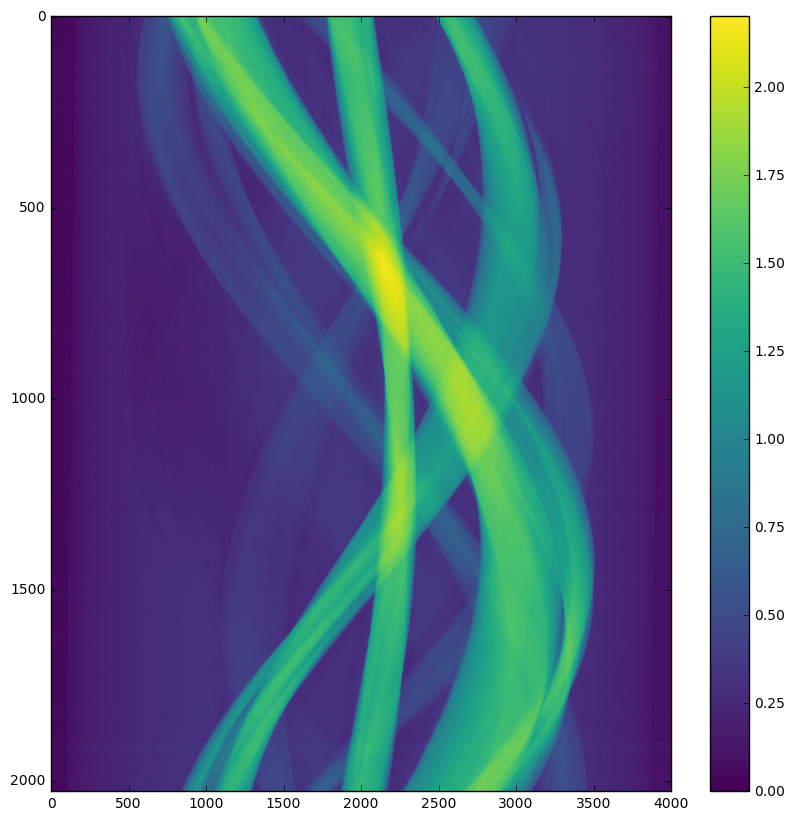

Time : 2.7628800869


In [9]:
# Simple preprocessing iages and save sinograms. 
t=time.time()

sinogram_blob = preprocess_sinogramm(data_blob, tmp_dir)

del data_blob
show_cuts(sinogram_blob)

print('Time : {}'.format(time.time()-t))

Time : 0.172101020813


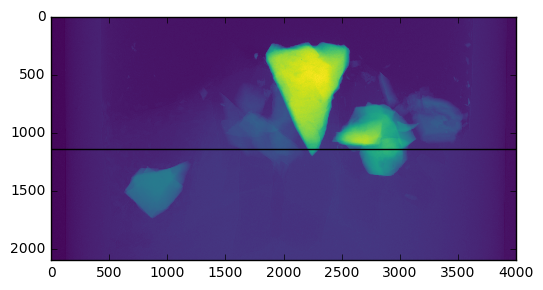

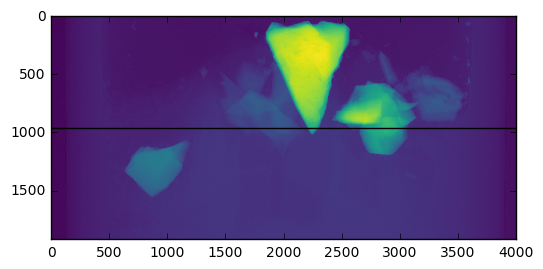

In [11]:
# Found boders for sinogram, centering  at optical line
t=time.time()


optical_axis = int(config['Acquisition']['Optical Axis (line)'])
start_line, stop_line = find_start_stop_slices(optical_axis, sinogram_blob)

plt.figure()
plt.imshow(sinogram_blob[sinogram_blob.shape[0]//2])
plt.hlines(sinogram_blob.shape[1]-optical_axis,0,sinogram_blob.shape[2])
    
fixed_image = sinogram_blob[sinogram_blob.shape[0]//2][start_line:stop_line]
plt.figure()
plt.imshow(fixed_image)
plt.hlines(optical_axis,0,fixed_image.shape[1])

print('Time : {}'.format(time.time()-t))

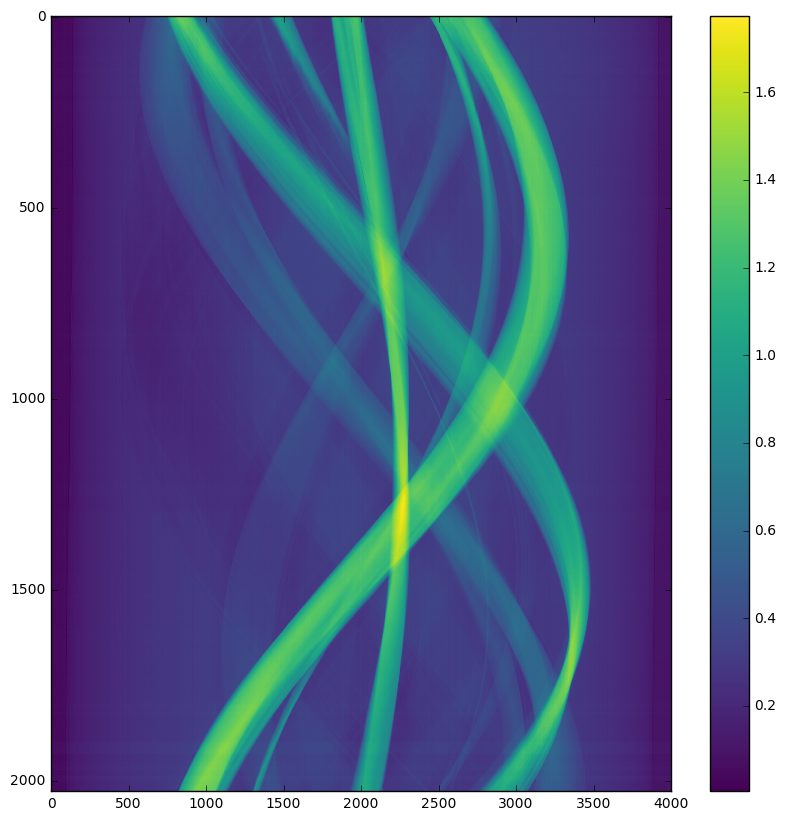

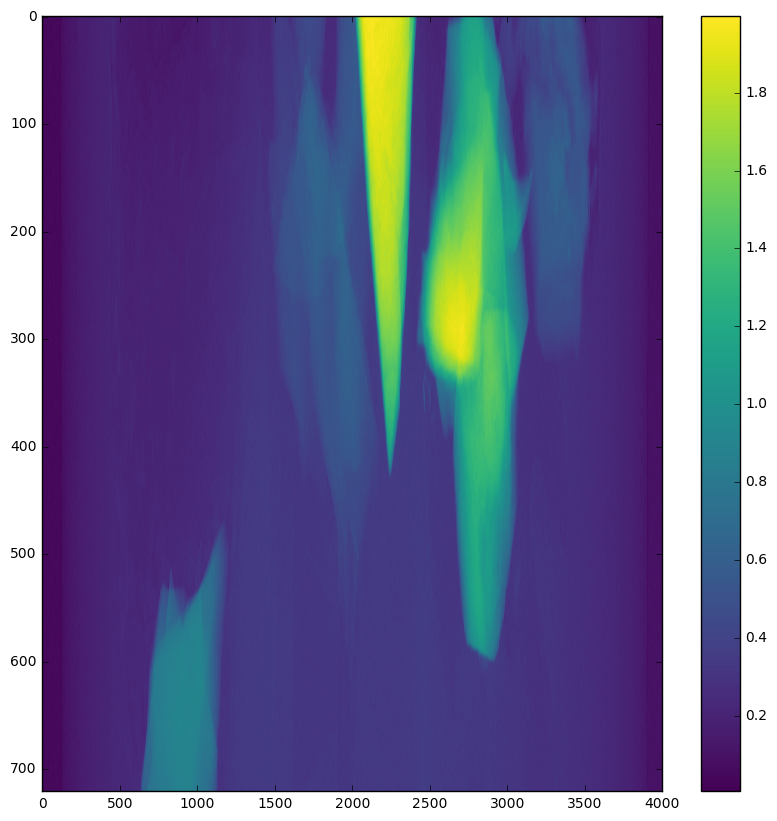

Time : 84.6662499905


In [12]:
#Save centered sinogram in sutable for astra format
t=time.time()

    
sinogram_croped_blob = crop_sinogram(sinogram_blob, start_line+600, stop_line-600)

show_cuts(sinogram_croped_blob)
# del sinogram_blob
print('Time : {}'.format(time.time()-t))

In [13]:
#Building ASTRA structures and run reconstruction
t=time.time()

rec_volume = reconstruct(config, sinogram_croped_blob, tmp_dir)
print('Time : {}'.format(time.time()-t))

Start reconstruction
Stop reconstruction
364.863550901
id  init  description
-----------------------------------------
1 	v     4000x2029x721 sinogram data 	
2 	v     4000x4000x721 volume data 	
-----------------------------------------

Time : 364.864192963


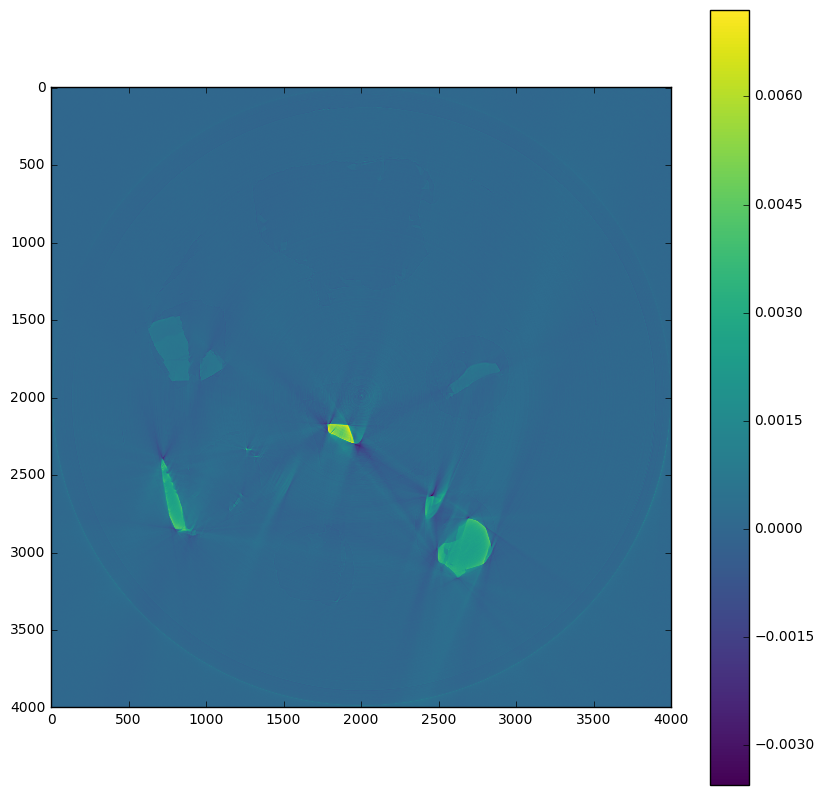

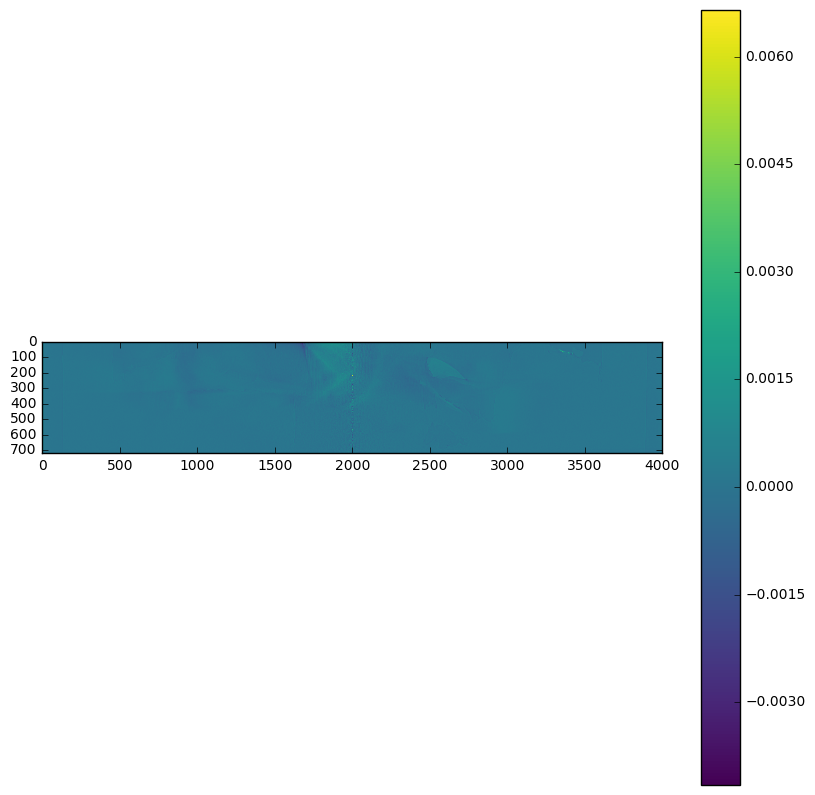

In [19]:
show_cuts(rec_volume)

In [27]:
#for fast reconstruction loading
# rec_volume = np.memmap(os.path.join(tmp_dir,'rec.tmp'),
#                             dtype='float32', mode='r', 
#                             shape=tuple(np.loadtxt(os.path.join(tmp_dir,'rec.size.txt')).astype('uint16'))
#                        )